# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomPerspective(0.3, 0.5, fill=(0,)),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),    # Input -  28x28x1, Output -  28x28x8, RF - 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),   # Input -  28x28x8, Output - 28x28x10, RF - 5x5
            nn.ReLU(),
        )

        self.tblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 28x28x10, Output - 14x14x10, RF - 6x6
        )

        self.cblock2 = nn.Sequential(
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # Input - 14x14x10, Output - 14x14x16, RF - 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input - 14x14x16, Output - 14x14x16, RF - 14x14
            nn.ReLU(),
        )

        self.tblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 14x14x16, Output -   7x7x16, RF - 16x16
        )

        self.cblock3 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input -   7x7x16, Output -   7x7x16, RF - 24x24
            nn.ReLU(),
        )

        self.outblock = nn.Sequential(
            nn.AvgPool2d(7, 7),                           # Input -   7x7x16, Output -   1x1x16, RF - 48x48
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.outblock(x)
        return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 10, 28, 28]             720
              ReLU-5           [-1, 10, 28, 28]               0
         MaxPool2d-6           [-1, 10, 14, 14]               0
       BatchNorm2d-7           [-1, 10, 14, 14]              20
            Conv2d-8           [-1, 16, 14, 14]           1,440
              ReLU-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
             ReLU-12           [-1, 16, 14, 14]               0
        MaxPool2d-13             [-1, 16, 7, 7]               0
      BatchNorm2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),    # Input -  28x28x1, Output -  28x28x8, RF - 3x3
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=4),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),   # Input -  28x28x8, Output - 28x28x10, RF - 5x5
            nn.ReLU(),
        )

        self.tblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 28x28x10, Output - 14x14x10, RF - 6x6
        )

        self.cblock2 = nn.Sequential(
            GhostBatchNorm(num_features=10, num_splits=4),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # Input - 14x14x10, Output - 14x14x16, RF - 10x10
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=4),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input - 14x14x16, Output - 14x14x16, RF - 14x14
            nn.ReLU(),
        )

        self.tblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 14x14x16, Output -   7x7x16, RF - 16x16
        )

        self.cblock3 = nn.Sequential(
            GhostBatchNorm(num_features=16, num_splits=4),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input -   7x7x16, Output -   7x7x16, RF - 24x24
            nn.ReLU(),
        )

        self.outblock = nn.Sequential(
            nn.AvgPool2d(7, 7),                           # Input -   7x7x16, Output -   1x1x16, RF - 48x48
            GhostBatchNorm(num_features=16, num_splits=4),
            nn.Conv2d(16, 32, 1, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=32, num_splits=4),
            nn.Conv2d(32, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.outblock(x)
        return x

In [ ]:
model_gbn = NetGBN().to(device)
# summary(model_gbn, input_size=(1, 28, 28))

In [ ]:
from tqdm import tqdm
#for plotting graphs

train_losses_withl1_bn, train_losses_withl2_bn, train_losses_withl1_l2_bn, train_losses_with_gbn, train_losses_withl1_l2_gbn = [], [], [], [], []
test_acc_with_l1_bn, test_acc_with_l2_bn, test_acc_with_l1_l2_bn, test_acc_with_gbn, test_acc_with_l1_l2_gbn = [], [], [], [], []
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lambda_l1 = 0.0005

def train(model, device, train_loader, optimizer, epoch, include_l1 = "no"):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)
    
    loss = F.nll_loss(y_pred, target)
    if include_l1 == "yes":
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
 

    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_losses = []
    #test_acc = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    #print(test_acc)
    return test_loss

# Let's Train and test our model

In [ ]:
def l1_with_bn(optimizer, scheduler):
  print("------------L1 with BATCH NORMALIZATION------------")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, include_l1 = "yes")
      test_loss = test(model, device, test_loader)
      scheduler.step(test_loss)

def l2_with_bn(optimizer, scheduler):
  print("------------L2 with BATCH NORMALIZATION------------")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, include_l1 = "no")
      test_loss = test(model, device, test_loader)
      scheduler.step(test_loss)
  
def l1_l2_with_bn(optimizer, scheduler):
  print("------------L1 & L2 with BATCH NORMALIZATION------------")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, include_l1 = "yes")
      test_loss = test(model, device, test_loader)
      scheduler.step(test_loss)

def with_gbn(optimizer, scheduler):
  print("------------With GHOST BATCH NORMALIZATION------------")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model_gbn, device, train_loader, optimizer, epoch, include_l1 = "no")
      test_loss = test(model_gbn, device, test_loader)
      scheduler.step(test_loss)

def l1_l2_with_gbn(optimizer, scheduler):
  print("------------L1 & L2 with GHOST BATCH NORMALIZATION------------")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model_gbn, device, train_loader, optimizer, epoch, include_l1 = "yes")
      test_loss = test(model_gbn, device, test_loader)
      scheduler.step(test_loss)


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

regularizations = ["l1_with_bn", "l2_with_bn", "l1_l2_with_bn", "with_gbn", "l1_l2_with_gbn"]

EPOCHS = 25
for regularization in regularizations:
  if regularization == "l1_with_bn":
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    l1_with_bn(optimizer, scheduler)
    train_losses_withl1_bn = train_losses
    test_acc_with_l1_bn = test_acc
  elif regularization == "l2_with_bn":
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 1e-3)
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    l2_with_bn(optimizer, scheduler)
    train_losses_withl2_bn = train_losses
    test_acc_with_l2_bn = test_acc
  elif regularization == "l1_l2_with_bn":
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 1e-3)
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    l1_l2_with_bn(optimizer, scheduler)
    train_losses_withl1_l2_bn = train_losses
    test_acc_with_l1_l2_bn = test_acc
  elif regularization == "with_gbn":
    optimizer = optim.SGD(model_gbn.parameters(), lr=0.01, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    with_gbn(optimizer, scheduler)
    train_losses_with_gbn = train_losses
    test_acc_with_gbn = test_acc
    torch.save(model_gbn, '/content/drive/My Drive/Colab Notebooks/model_gbn')
  elif regularization == "l1_l2_with_gbn":
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 1e-3)
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    l1_l2_with_gbn(optimizer, scheduler)
    train_losses_withl1_l2_gbn = train_losses
    test_acc_with_l1_l2_gbn = test_acc
  train_losses, test_acc = [], []


  0%|          | 0/938 [00:00<?, ?it/s]

------------L1 with BATCH NORMALIZATION------------
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=0.33230680227279663 Batch_id=937 Accuracy=94.69: 100%|██████████| 938/938 [00:31<00:00, 29.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0791, Accuracy: 9745/10000 (97.45%)

EPOCH: 1


Loss=0.3568887710571289 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:31<00:00, 29.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9824/10000 (98.24%)

EPOCH: 2


Loss=0.23749685287475586 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:32<00:00, 28.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.3123549818992615 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:31<00:00, 29.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9699/10000 (96.99%)

EPOCH: 4


Loss=0.18800371885299683 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:30<00:00, 30.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.23217298090457916 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:31<00:00, 29.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Loss=0.18796734511852264 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:32<00:00, 29.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9805/10000 (98.05%)

EPOCH: 7


Loss=0.2653428614139557 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:32<00:00, 28.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0748, Accuracy: 9758/10000 (97.58%)

EPOCH: 8


Loss=0.2713361084461212 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:32<00:00, 28.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1495, Accuracy: 9530/10000 (95.30%)

Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
EPOCH: 9


Loss=0.25931215286254883 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:32<00:00, 28.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.1536933332681656 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:33<00:00, 28.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.1411566585302353 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:33<00:00, 28.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.3131166994571686 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:32<00:00, 28.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.17680059373378754 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
EPOCH: 14


Loss=0.15172182023525238 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.17635546624660492 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:33<00:00, 28.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.13087263703346252 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:32<00:00, 28.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.13189522922039032 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:32<00:00, 28.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.13516774773597717 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:32<00:00, 28.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.15612106025218964 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:32<00:00, 28.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.17422263324260712 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:32<00:00, 28.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.1369289606809616 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:32<00:00, 28.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9926/10000 (99.26%)

EPOCH: 22


Loss=0.12561003863811493 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:32<00:00, 28.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 23


Loss=0.3266777992248535 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:32<00:00, 28.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.13554738461971283 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:32<00:00, 29.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

------------L2 with BATCH NORMALIZATION------------
EPOCH: 0


Loss=0.006703547202050686 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:28<00:00, 32.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.0073177395388484 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:28<00:00, 32.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9902/10000 (99.02%)

EPOCH: 2


Loss=0.01618530973792076 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:29<00:00, 32.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.0073825945146381855 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:28<00:00, 32.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.008940992876887321 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:28<00:00, 32.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.0247209295630455 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:28<00:00, 32.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.03915800526738167 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:29<00:00, 32.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.021974746137857437 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:28<00:00, 32.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
EPOCH: 8


Loss=0.04287413880228996 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.005532122682780027 Batch_id=937 Accuracy=99.64: 100%|██████████| 938/938 [00:28<00:00, 32.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


Loss=0.012693632394075394 Batch_id=937 Accuracy=99.66: 100%|██████████| 938/938 [00:29<00:00, 32.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.010579405352473259 Batch_id=937 Accuracy=99.65: 100%|██████████| 938/938 [00:29<00:00, 32.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.02673960290849209 Batch_id=937 Accuracy=99.70: 100%|██████████| 938/938 [00:28<00:00, 32.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.01779279112815857 Batch_id=937 Accuracy=99.70: 100%|██████████| 938/938 [00:29<00:00, 32.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.0055727045983076096 Batch_id=937 Accuracy=99.76: 100%|██████████| 938/938 [00:29<00:00, 32.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.002331668511033058 Batch_id=937 Accuracy=99.73: 100%|██████████| 938/938 [00:29<00:00, 32.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9948/10000 (99.48%)

EPOCH: 16


Loss=0.012640220113098621 Batch_id=937 Accuracy=99.72: 100%|██████████| 938/938 [00:28<00:00, 33.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.1131368950009346 Batch_id=937 Accuracy=99.76: 100%|██████████| 938/938 [00:28<00:00, 32.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.007692695129662752 Batch_id=937 Accuracy=99.78: 100%|██████████| 938/938 [00:28<00:00, 32.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.04059816896915436 Batch_id=937 Accuracy=99.76: 100%|██████████| 938/938 [00:29<00:00, 31.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
EPOCH: 20


Loss=0.0024844116996973753 Batch_id=937 Accuracy=99.80: 100%|██████████| 938/938 [00:28<00:00, 32.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.009447076357901096 Batch_id=937 Accuracy=99.80: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.007784097455441952 Batch_id=937 Accuracy=99.81: 100%|██████████| 938/938 [00:28<00:00, 33.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 23


Loss=0.018656691536307335 Batch_id=937 Accuracy=99.81: 100%|██████████| 938/938 [00:28<00:00, 32.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.0063384948298335075 Batch_id=937 Accuracy=99.83: 100%|██████████| 938/938 [00:29<00:00, 31.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

------------L1 & L2 with BATCH NORMALIZATION------------
EPOCH: 0


Loss=0.18762028217315674 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:33<00:00, 28.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9845/10000 (98.45%)

EPOCH: 1


Loss=0.17897558212280273 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:32<00:00, 28.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9740/10000 (97.40%)

EPOCH: 2


Loss=0.16674724221229553 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:32<00:00, 28.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9824/10000 (98.24%)

EPOCH: 3


Loss=0.16965994238853455 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:33<00:00, 27.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0791, Accuracy: 9763/10000 (97.63%)

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
EPOCH: 4


Loss=0.1350024789571762 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:33<00:00, 28.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.12693607807159424 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:33<00:00, 28.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.1403387486934662 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:32<00:00, 28.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.16711613535881042 Batch_id=620 Accuracy=99.29:  66%|██████▌   | 617/938 [00:21<00:10, 30.12it/s]

Buffered data was truncated after reaching the output size limit.

Text(0.5, 1.0, 'Validation Accuracy')

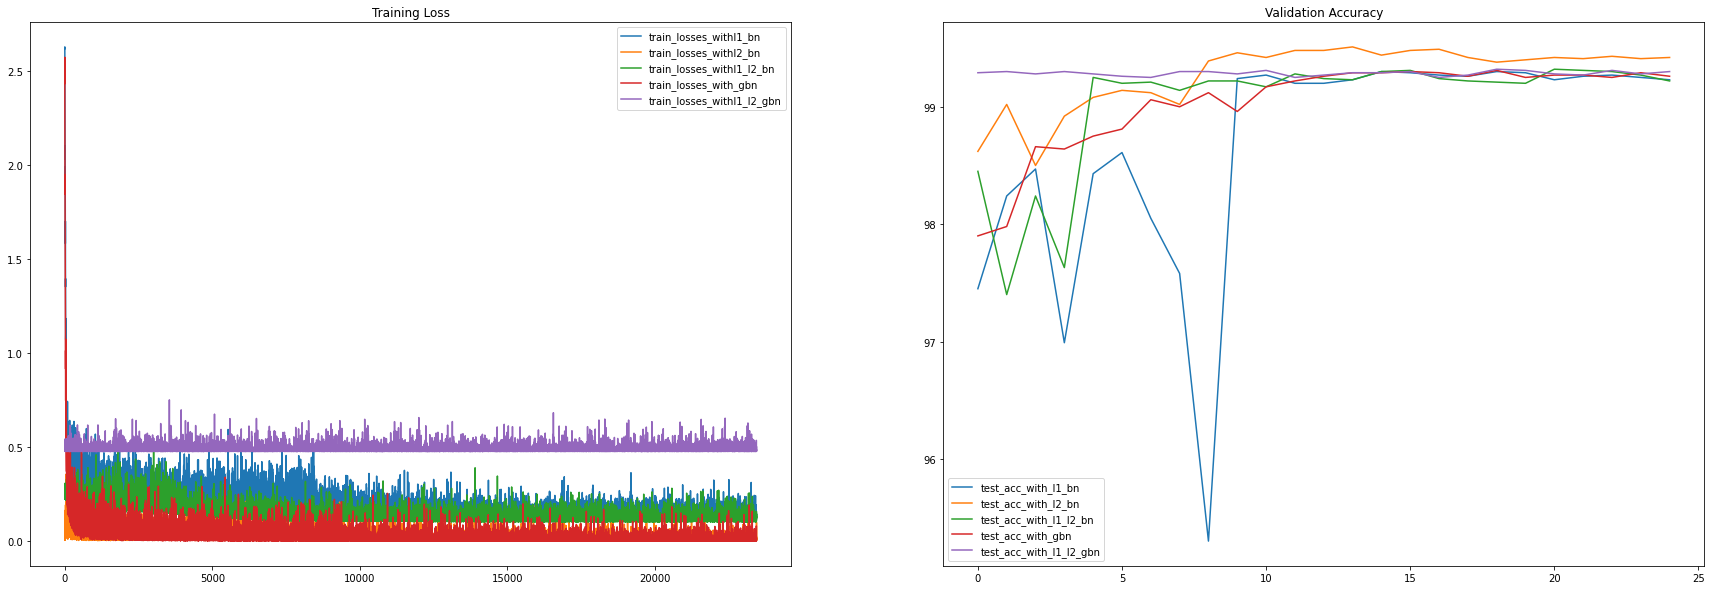

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(30,10))
print(axs)
axs[0].plot(train_losses_withl1_bn, label = "train_losses_withl1_bn")
axs[0].plot(train_losses_withl2_bn, label = "train_losses_withl2_bn")
axs[0].plot(train_losses_withl1_l2_bn, label = "train_losses_withl1_l2_bn")
axs[0].plot(train_losses_with_gbn, label = "train_losses_with_gbn")
axs[0].plot(train_losses_withl1_l2_gbn, label = "train_losses_withl1_l2_gbn")
axs[0].legend()
axs[0].set_title("Training Loss")

axs[1].plot(test_acc_with_l1_bn, label = "test_acc_with_l1_bn")
axs[1].plot(test_acc_with_l2_bn, label = "test_acc_with_l2_bn")
axs[1].plot(test_acc_with_l1_l2_bn, label = "test_acc_with_l1_l2_bn")
axs[1].plot(test_acc_with_gbn, label = "test_acc_with_gbn")
axs[1].plot(test_acc_with_l1_l2_gbn, label = "test_acc_with_l1_l2_gbn")
axs[1].legend()
axs[1].set_title("Validation Accuracy")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


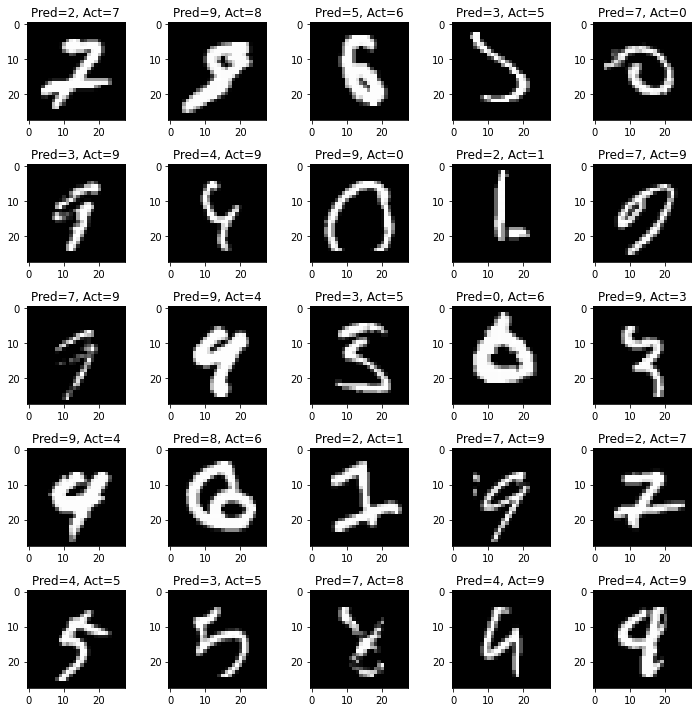

In [15]:
gbn = torch.load('/content/drive/My Drive/Colab Notebooks/model_gbn')

def misclassified_images(model, device, test_loader):
    model.eval()
    result = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            prediction_ = pred.squeeze(-1)
            target_ = target.view_as(pred).squeeze(-1)
            for i in range(pred.size(0)):
              if prediction_[i]!=target_[i]:
                result.append([prediction_[i], target_[i], data[i]])
    return result

def plot_wrong_images(result):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(result[i][2].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Pred={}, Act={}".format(str(result[i][0].data.cpu().numpy()),str(result[i][1].data.cpu().numpy())))
  plt.tight_layout()
  plt.show()

result = misclassified_images(gbn, device, test_loader)
plot_wrong_images(result)